# 05_Drop-MT-SIMBA

In [2]:
%load_ext autoreload
%autoreload 2

In [175]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from src.plot import plot_spatial, palette_celltype, palette_entity_anno, qqplot
import numpy as np
import pandas as pd
import copy
import squidpy as sq

palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "lightgray"

In [4]:
import os
import simba as si
si.__version__

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_si

'1.2'

In [184]:
si.settings.set_figure_params(
    dpi=80,
    style='white',
    fig_size=[5,5],
    rc={'image.cmap': 'viridis'}
)

In [185]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

In [5]:
workdir = 'data/05'
si.settings.set_workdir(workdir)

Saving results in: data/05


# Original preprocessed data

Already normalized with MT genes included?

In [127]:
h5_fn = "./result_simba_rnaseq_spatialLIBD/data/151673.h5ad"
adata_CG = sc.read_h5ad(h5_fn)
adata_CG

AnnData object with n_obs × n_vars = 3611 × 16578
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'spatialLIBD', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [128]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_CG.var["mt"] = adata_CG.var_names.str.startswith("MT-")
# ribosomal genes
adata_CG.var["ribo"] = adata_CG.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_CG.var["hb"] = adata_CG.var_names.str.contains("^HB[^(P)]")


In [129]:
sc.pp.calculate_qc_metrics(
    adata_CG, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

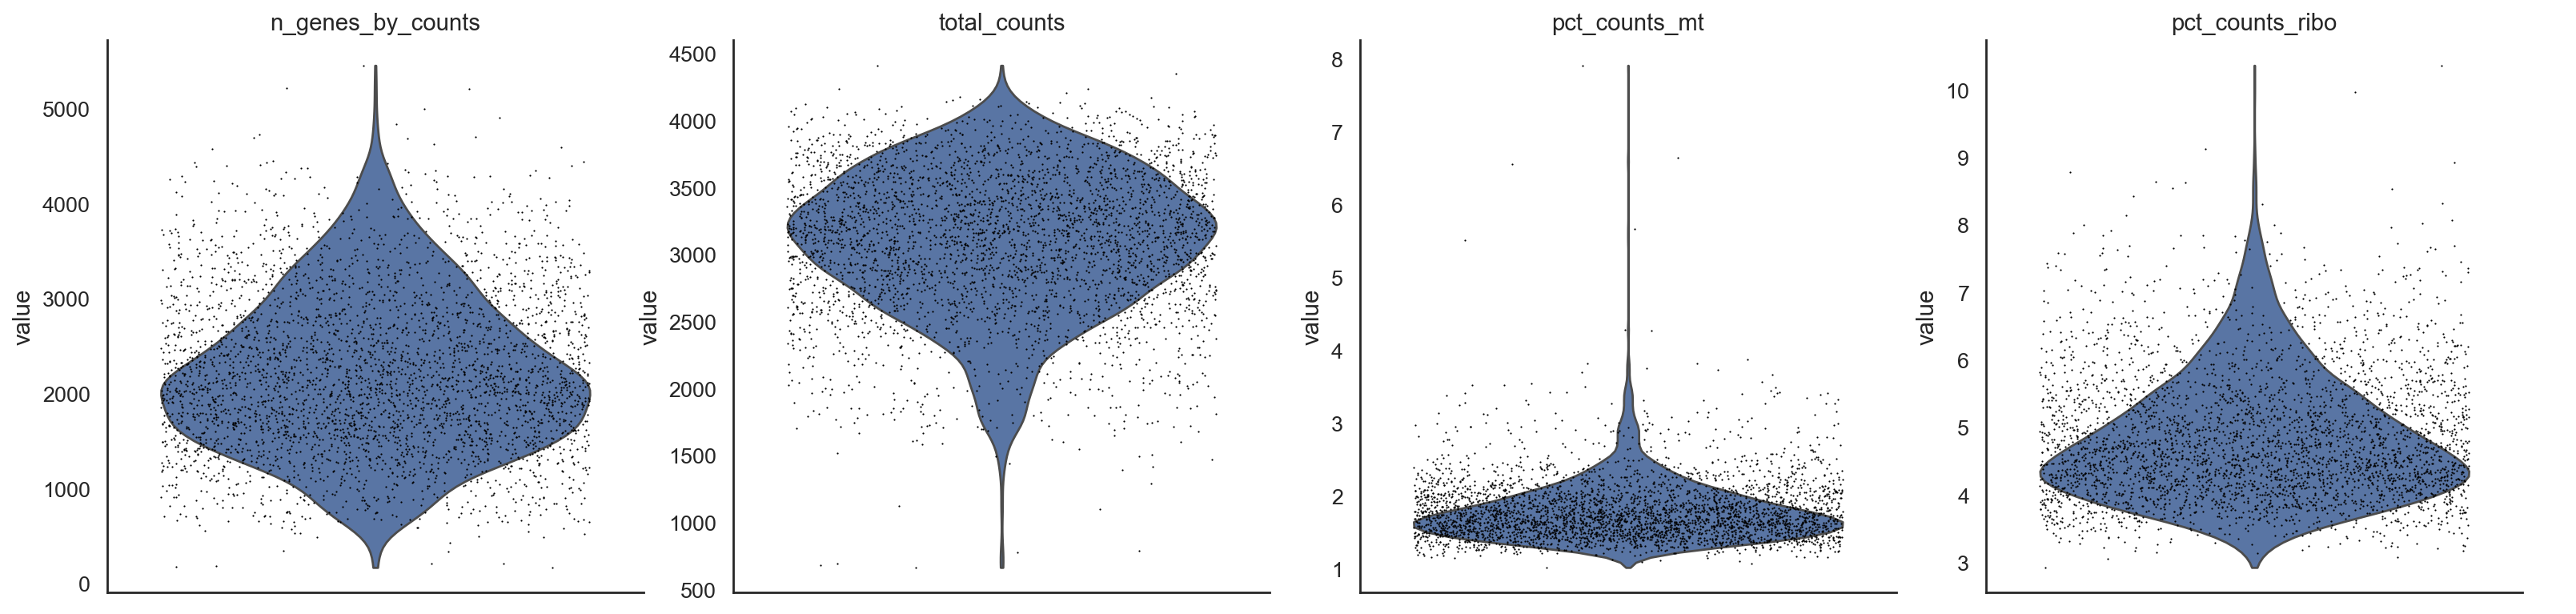

In [186]:
sc.pl.violin(
    adata_CG,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
)

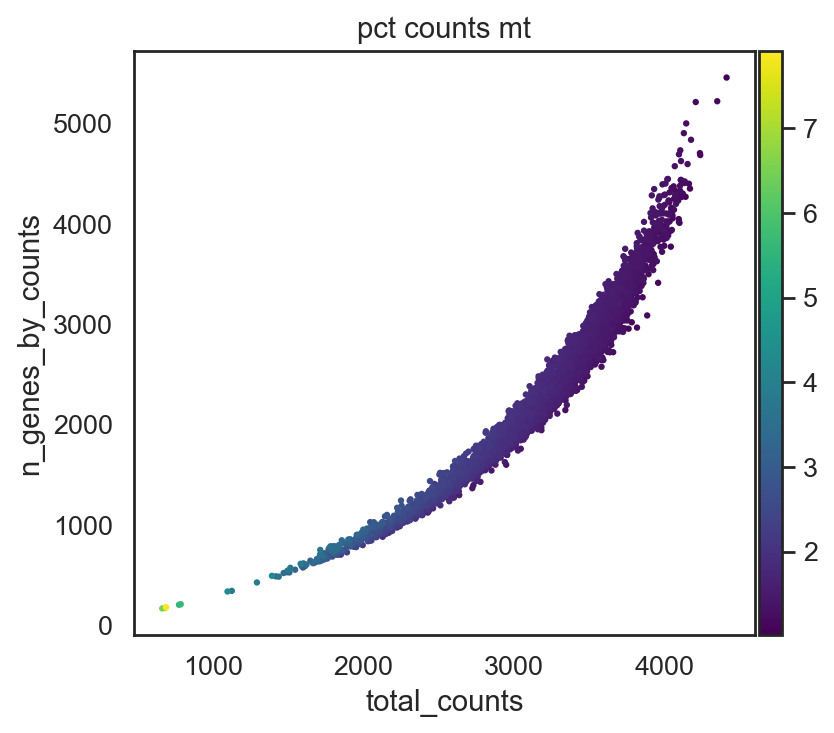

In [187]:
sc.pl.scatter(adata_CG, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

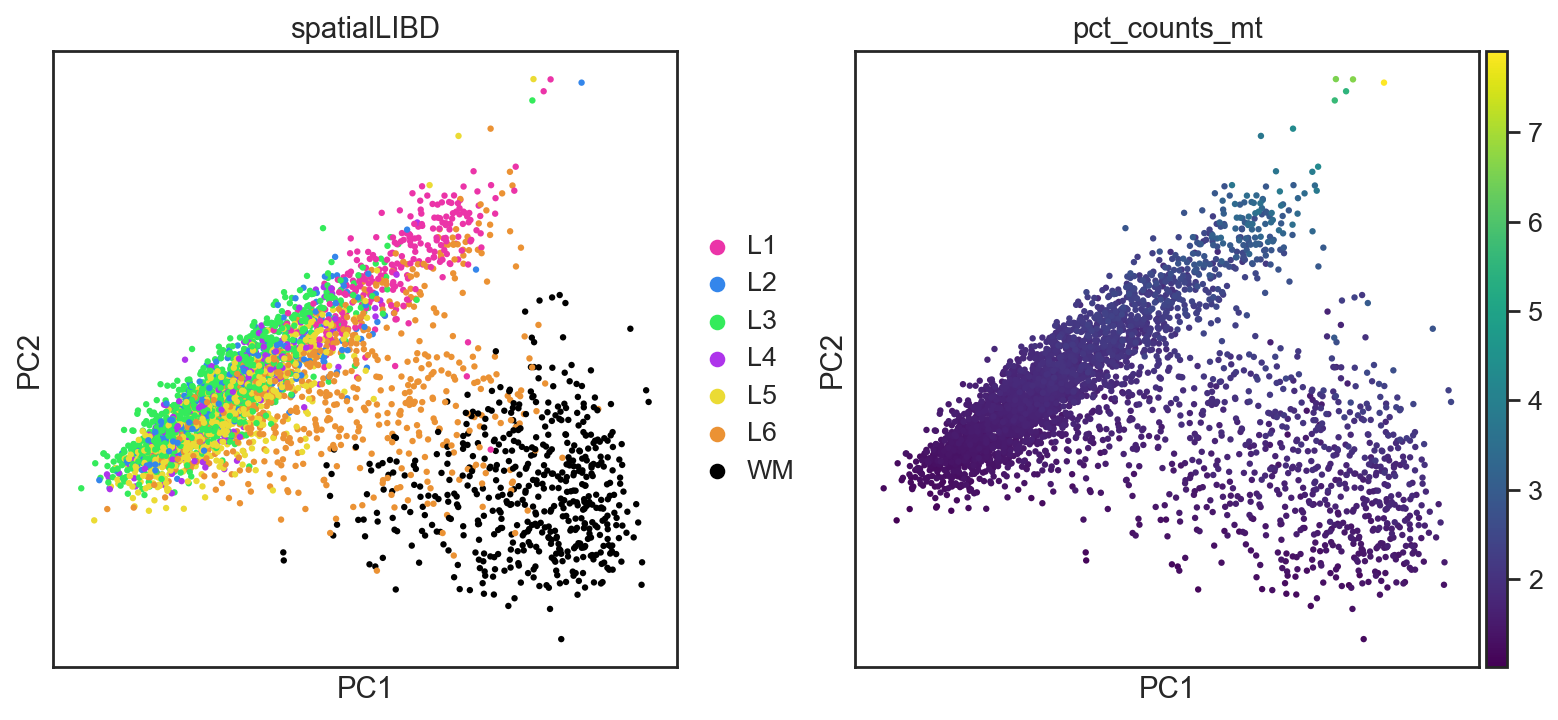

In [188]:
sc.pl.pca(adata_CG, color=['spatialLIBD', 'pct_counts_mt'], palette=palette_celltype)

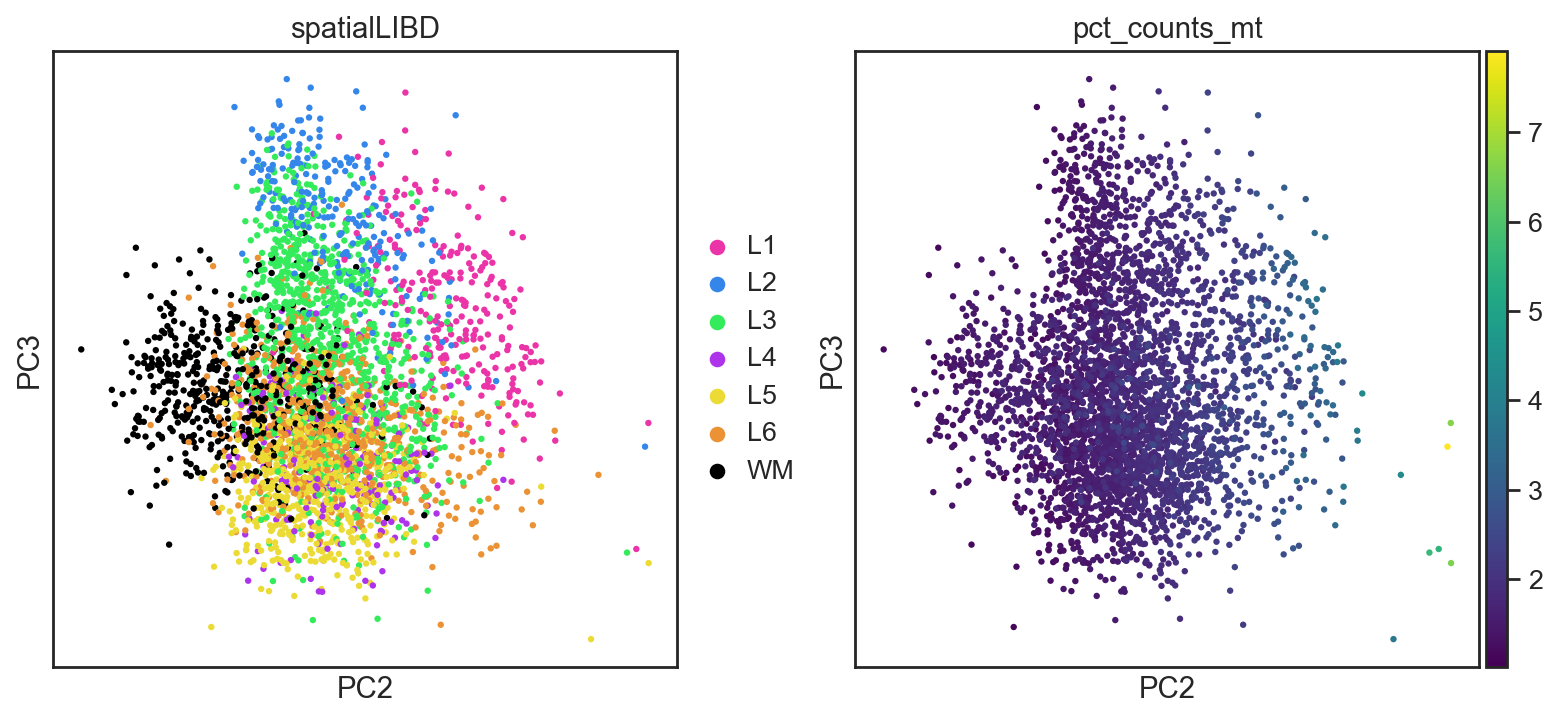

In [189]:
sc.pl.pca(adata_CG, color=['spatialLIBD', 'pct_counts_mt'], palette=palette_celltype, dimensions=(1, 2))

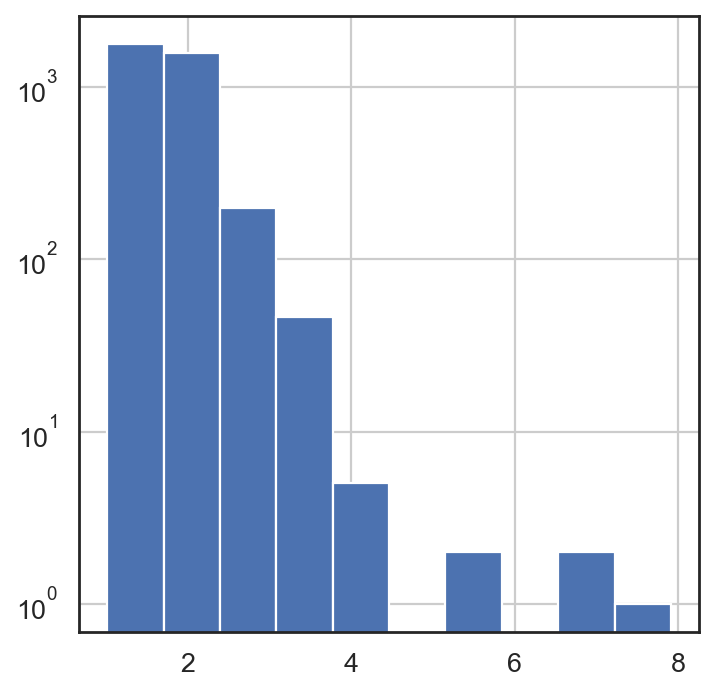

In [190]:
adata_CG.obs['pct_counts_mt'].hist()
plt.yscale('log')

/var/folders/h3/49kgmgs54yv7pd7wbst2wfv80000gp/T/ipykernel_78582/3877535342.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(adata_CG.obs, x='spatialLIBD', y='pct_counts_mt', palette=palette_celltype)


<Axes: xlabel='spatialLIBD', ylabel='pct_counts_mt'>

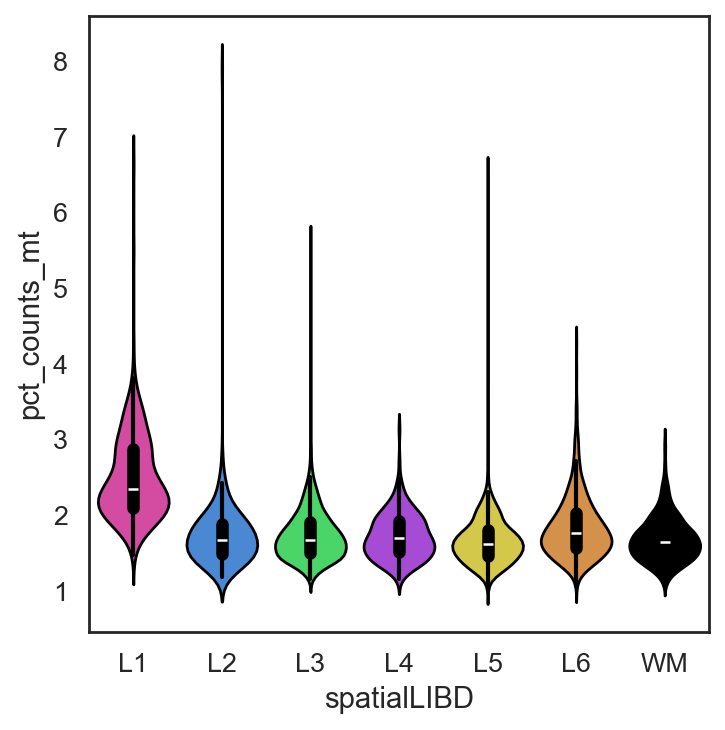

In [191]:
sns.violinplot(adata_CG.obs, x='spatialLIBD', y='pct_counts_mt', palette=palette_celltype)

# Filters

In [135]:
si.pp.filter_genes(adata_CG,min_n_cells=3)
# si.pp.filter_cells_rna(adata_CG,min_n_genes=100)

Before filtering: 
3611 cells, 16578 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
3611 cells, 16578 genes


Filter out cells with mito < 5%

In [136]:
adata_CG_filMT = adata_CG[adata_CG.obs['pct_counts_mt'] < 5, :].copy() # %

In [137]:
adata_CG.X.shape

(3611, 16578)

In [138]:
adata_CG.obs_names.shape

(3611,)

In [139]:
adata_CG_filMT.shape

(3606, 16578)

In [140]:
si.pp.cal_qc_rna(adata_CG_filMT)

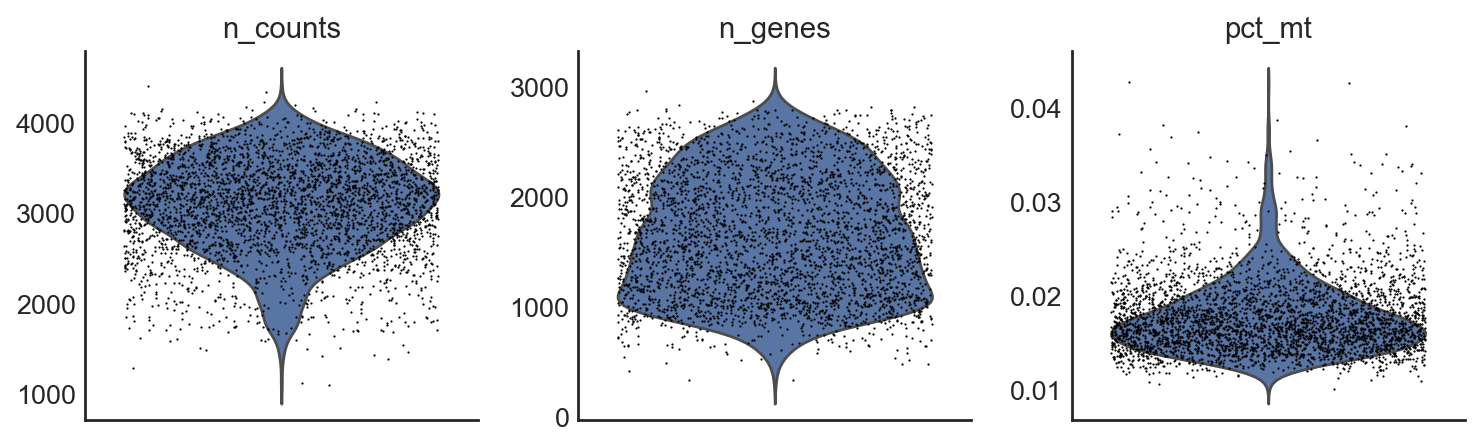

In [192]:
si.pl.violin(adata_CG_filMT,list_obs=['n_counts','n_genes','pct_mt'])

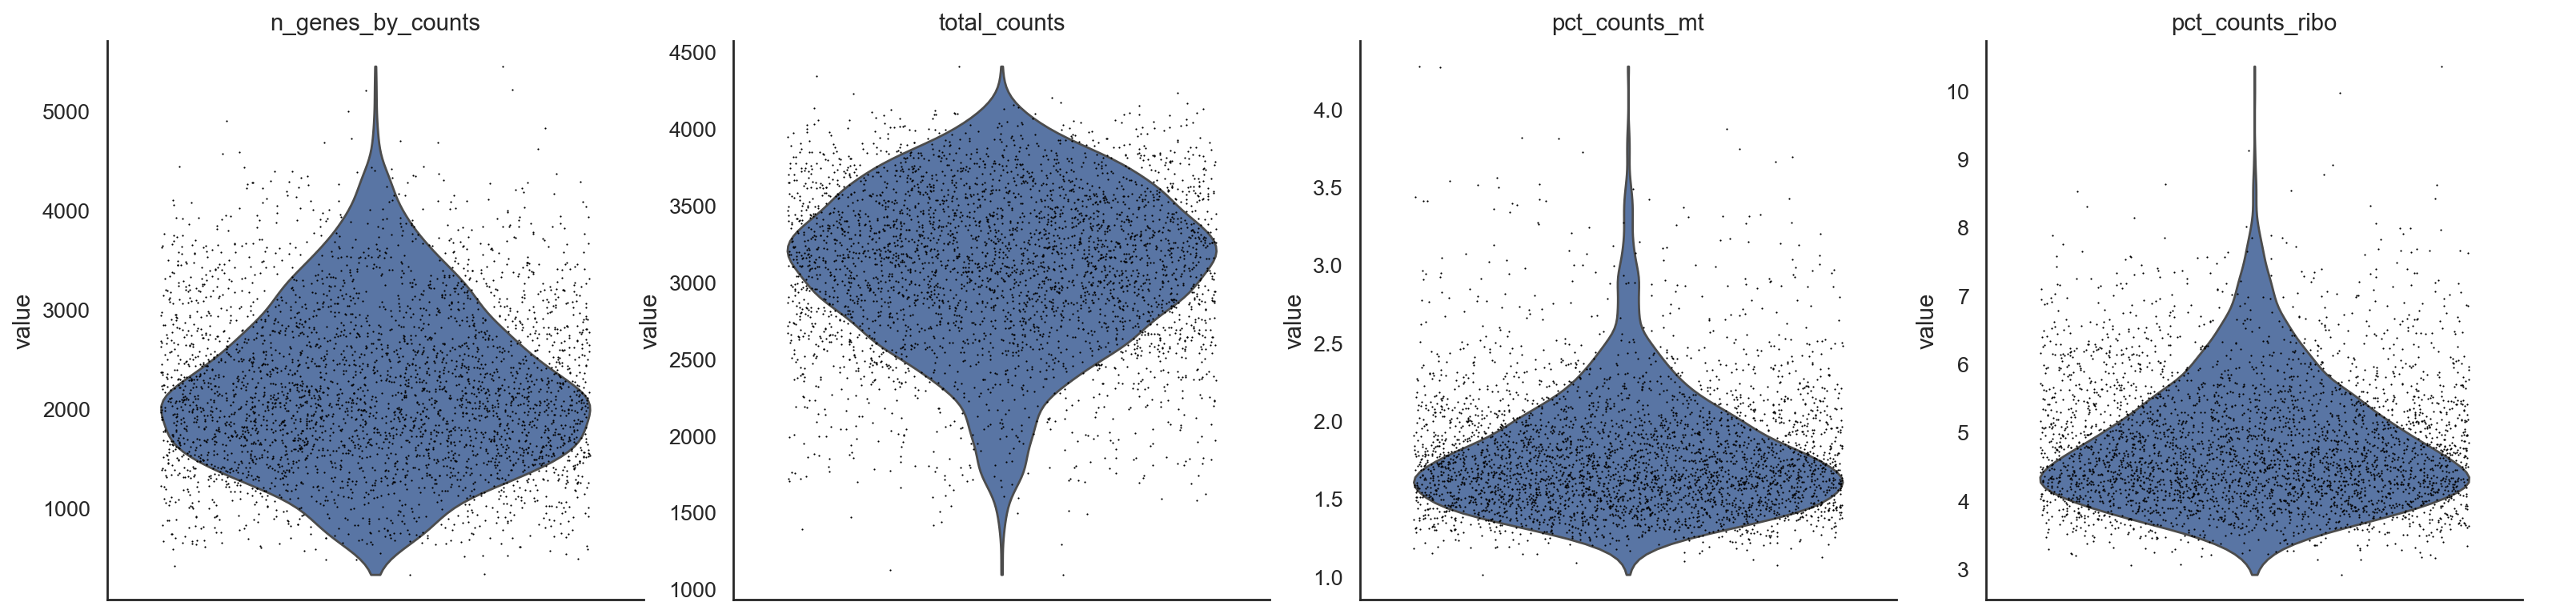

In [193]:
sc.pp.calculate_qc_metrics(
    adata_CG_filMT, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)
sc.pl.violin(
    adata_CG_filMT,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
)

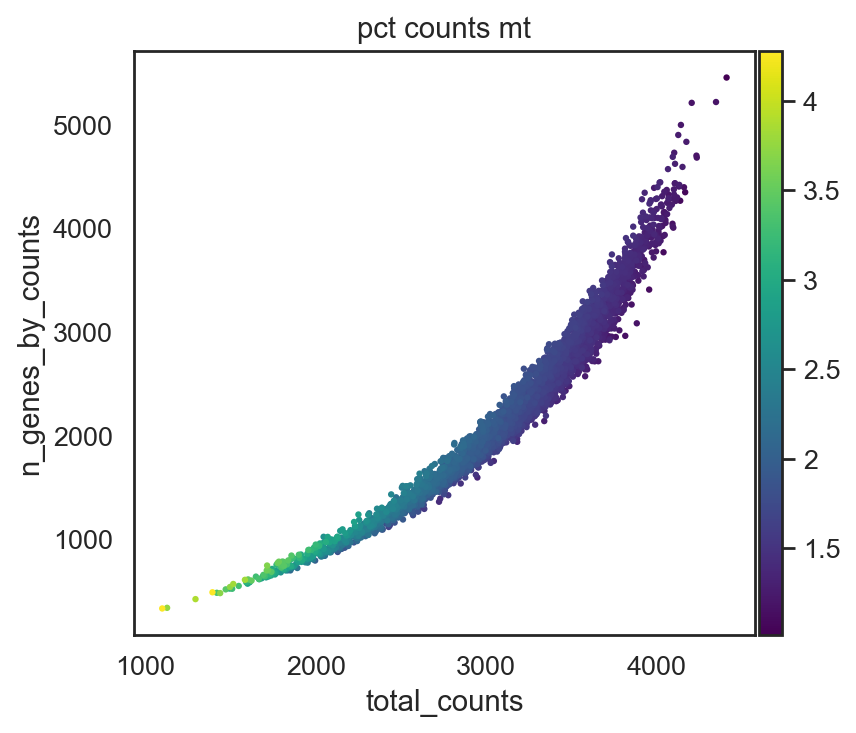

In [194]:
sc.pl.scatter(adata_CG_filMT, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

/var/folders/h3/49kgmgs54yv7pd7wbst2wfv80000gp/T/ipykernel_78582/3191846059.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(adata_CG_filMT.obs, x='spatialLIBD', y='pct_counts_mt', palette=palette_celltype)


<Axes: xlabel='spatialLIBD', ylabel='pct_counts_mt'>

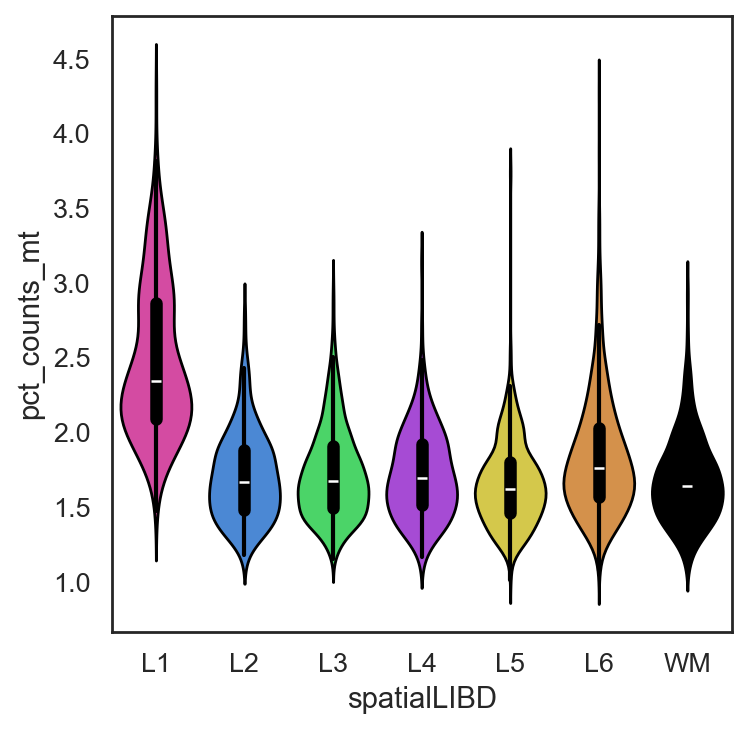

In [195]:
sns.violinplot(adata_CG_filMT.obs, x='spatialLIBD', y='pct_counts_mt', palette=palette_celltype)

# Remove MT genes before discretizing

In [144]:
adata_CG_filMT_noMT = adata_CG_filMT[:, ~adata_CG_filMT.var['mt']].copy()

In [146]:
adata_CG_filMT.shape

(3606, 16578)

In [147]:
adata_CG_filMT_noMT.shape

(3606, 16565)

/var/folders/h3/49kgmgs54yv7pd7wbst2wfv80000gp/T/ipykernel_78582/3415707379.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(adata_CG_filMT_noMT.obs, x='spatialLIBD', y='pct_counts_mt', palette=palette_celltype)


<Axes: xlabel='spatialLIBD', ylabel='pct_counts_mt'>

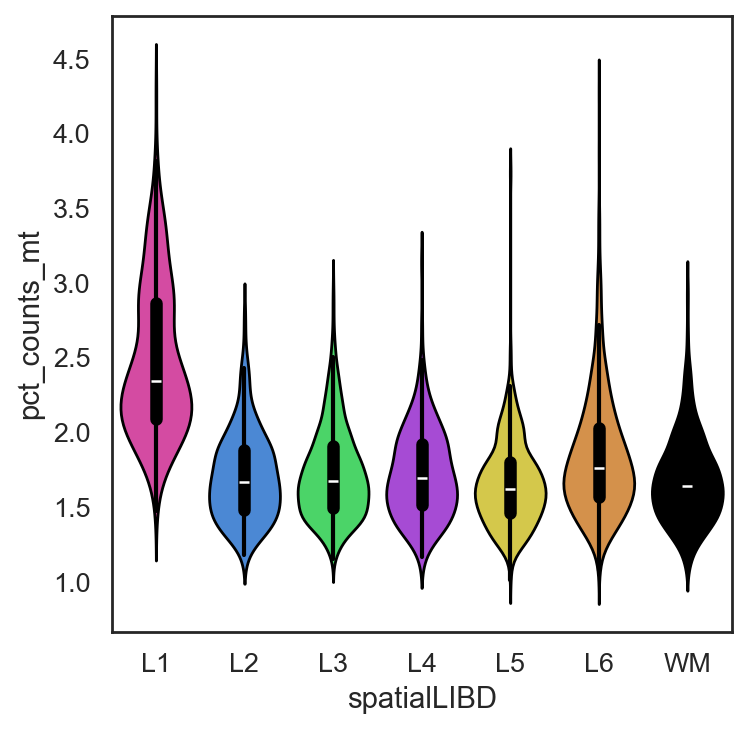

In [196]:
sns.violinplot(adata_CG_filMT_noMT.obs, x='spatialLIBD', y='pct_counts_mt', palette=palette_celltype)

# Discretize

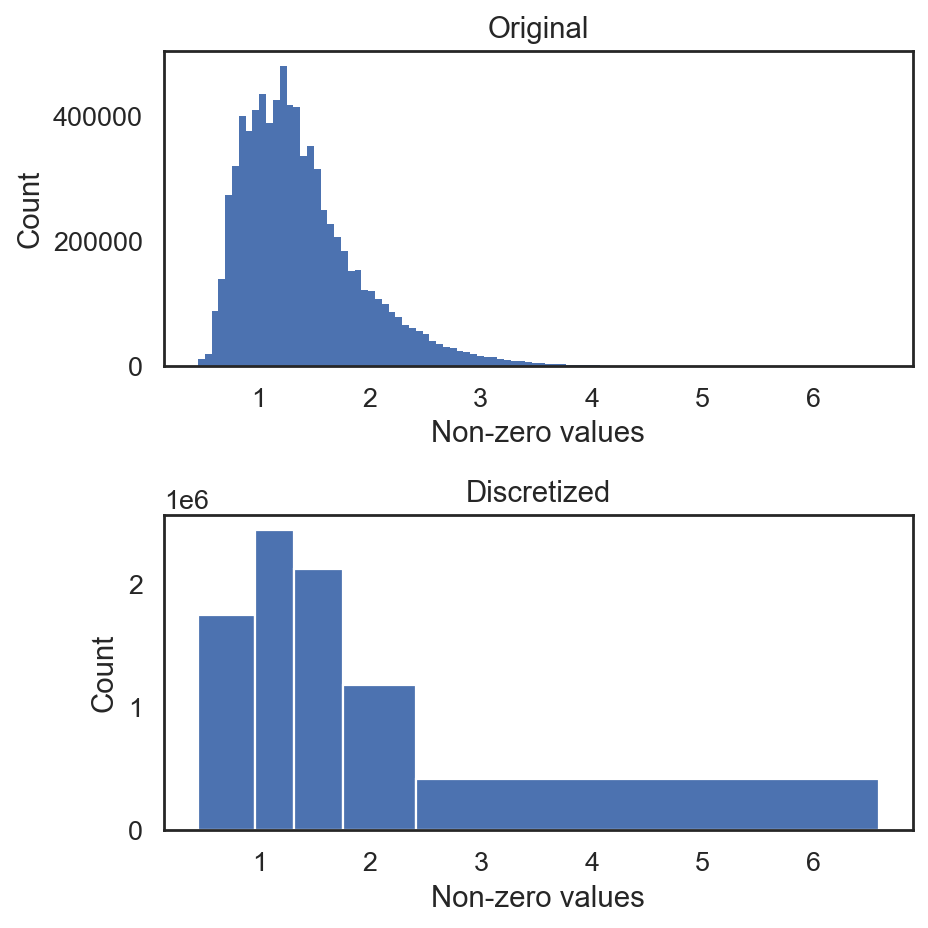

In [197]:
si.tl.discretize(adata_CG_filMT_noMT,n_bins=5)
si.pl.discretize(adata_CG_filMT_noMT,kde=False)

# Generate graph

In [150]:
si.tl.gen_graph(
    list_CG=[adata_CG_filMT_noMT],
    layer='simba',
    use_highly_variable=False, 
    dirname='graph_filMT_noMT'
)

relation0: source: C, destination: G
#edges: 1746802
relation1: source: C, destination: G
#edges: 2442896
relation2: source: C, destination: G
#edges: 2127023
relation3: source: C, destination: G
#edges: 1178782
relation4: source: C, destination: G
#edges: 415180
Total number of edges: 7910683
Writing graph file "pbg_graph.txt" to "data/05/pbg/graph_filMT_noMT" ...
Finished.


In [151]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model_filMT_noMT')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.004479
Weight decay being used for training is 0.004479
Converting input data ...
[2025-01-15 10:51:28.965430] Using the 5 relation types given in the config
[2025-01-15 10:51:28.966000] Searching for the entities in the edge files...
[2025-01-15 10:51:35.868662] Entity type C:
[2025-01-15 10:51:35.869183] - Found 3606 entities
[2025-01-15 10:51:35.869762] - Removing the ones with fewer than 1 occurrences...
[2025-01-15 10:51:35.870510] - Left with 3606 entities
[2025-01-15 10:51:35.871073] - Shuffling them...
[2025-01-15 10:51:35.872672] Entity type G:
[2025-01-15 10:51:35.873306] - Found 16565 entities
[2025-01-15 10:51:35.873745] - Removing the ones with fewer than 1 occurrences...
[2025-01-15 10:51:35.876576] - Left with 16565 entities
[2025-01-15 10:51:35.877210] - Shuffling them...
[2025-01-15 10:51:35.883968] Preparing counts and dictionaries for entities and relation types:
[2025-01-15 10:51:35.

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: T

Finished


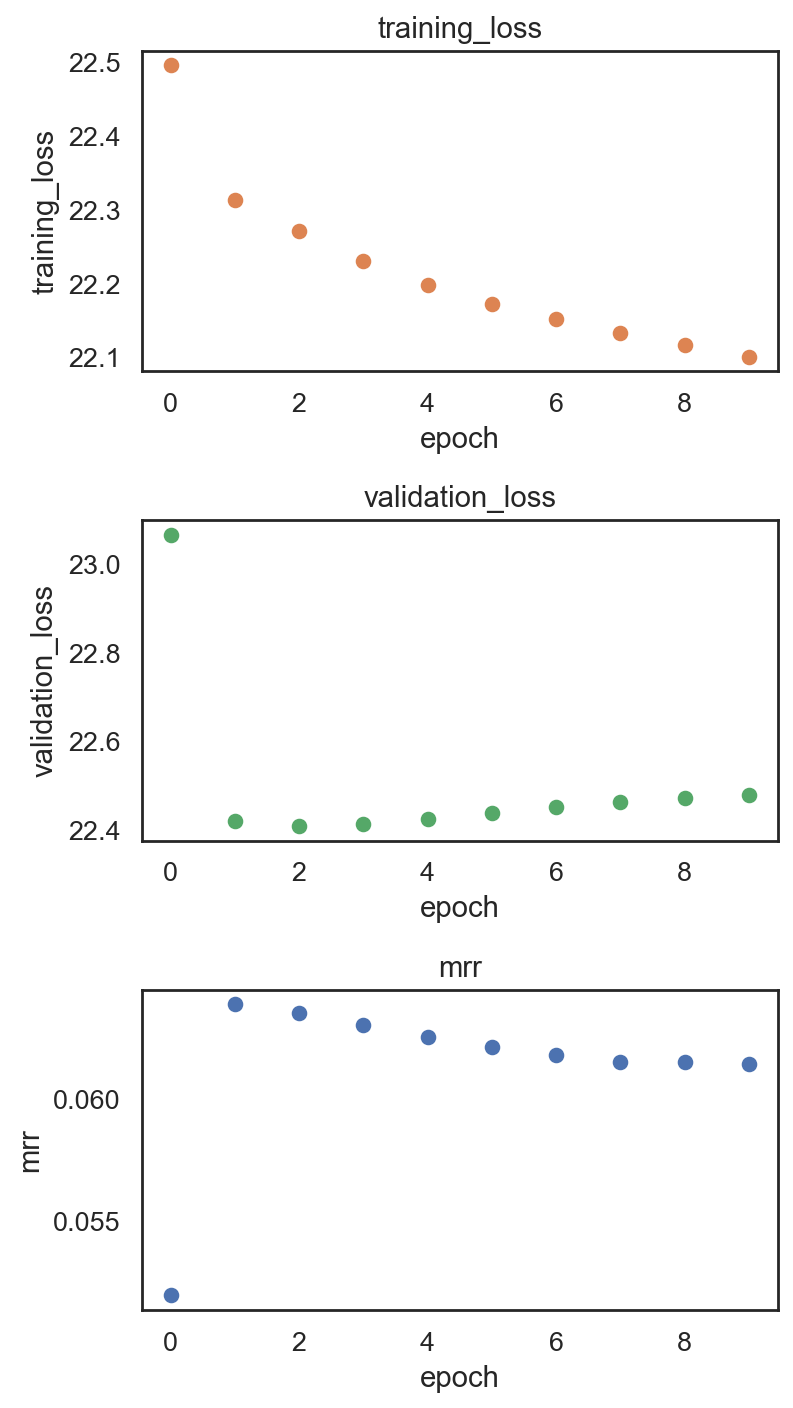

In [198]:
si.pl.pbg_metrics(fig_ncol=1)

# Post training

In [153]:
# read in entity embeddings obtained from pbg training.
dict_adata = si.read_embedding()
dict_adata

{'G': AnnData object with n_obs × n_vars = 16565 × 50,
 'C': AnnData object with n_obs × n_vars = 3606 × 50}

In [154]:
adata_C = dict_adata['C']  # embeddings of cells
adata_G = dict_adata['G']  # embeddings of genes

In [156]:
adata_C.obs['spatialLIBD'] = adata_CG_filMT_noMT[adata_CG_filMT_noMT.obs_names,:].obs['spatialLIBD'].copy()
adata_C.obs['n_counts'] = adata_CG_filMT_noMT[adata_CG_filMT_noMT.obs_names,:].obs['n_counts'].copy()
adata_C.obs['n_genes'] = adata_CG_filMT_noMT[adata_CG_filMT_noMT.obs_names,:].obs['n_genes'].copy()
adata_C.obs['pct_counts_mt'] = adata_CG_filMT_noMT[adata_CG_filMT_noMT.obs_names,:].obs['pct_counts_mt'].copy()
adata_C

AnnData object with n_obs × n_vars = 3606 × 50
    obs: 'spatialLIBD', 'n_counts', 'n_genes', 'pct_counts_mt'

In [169]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


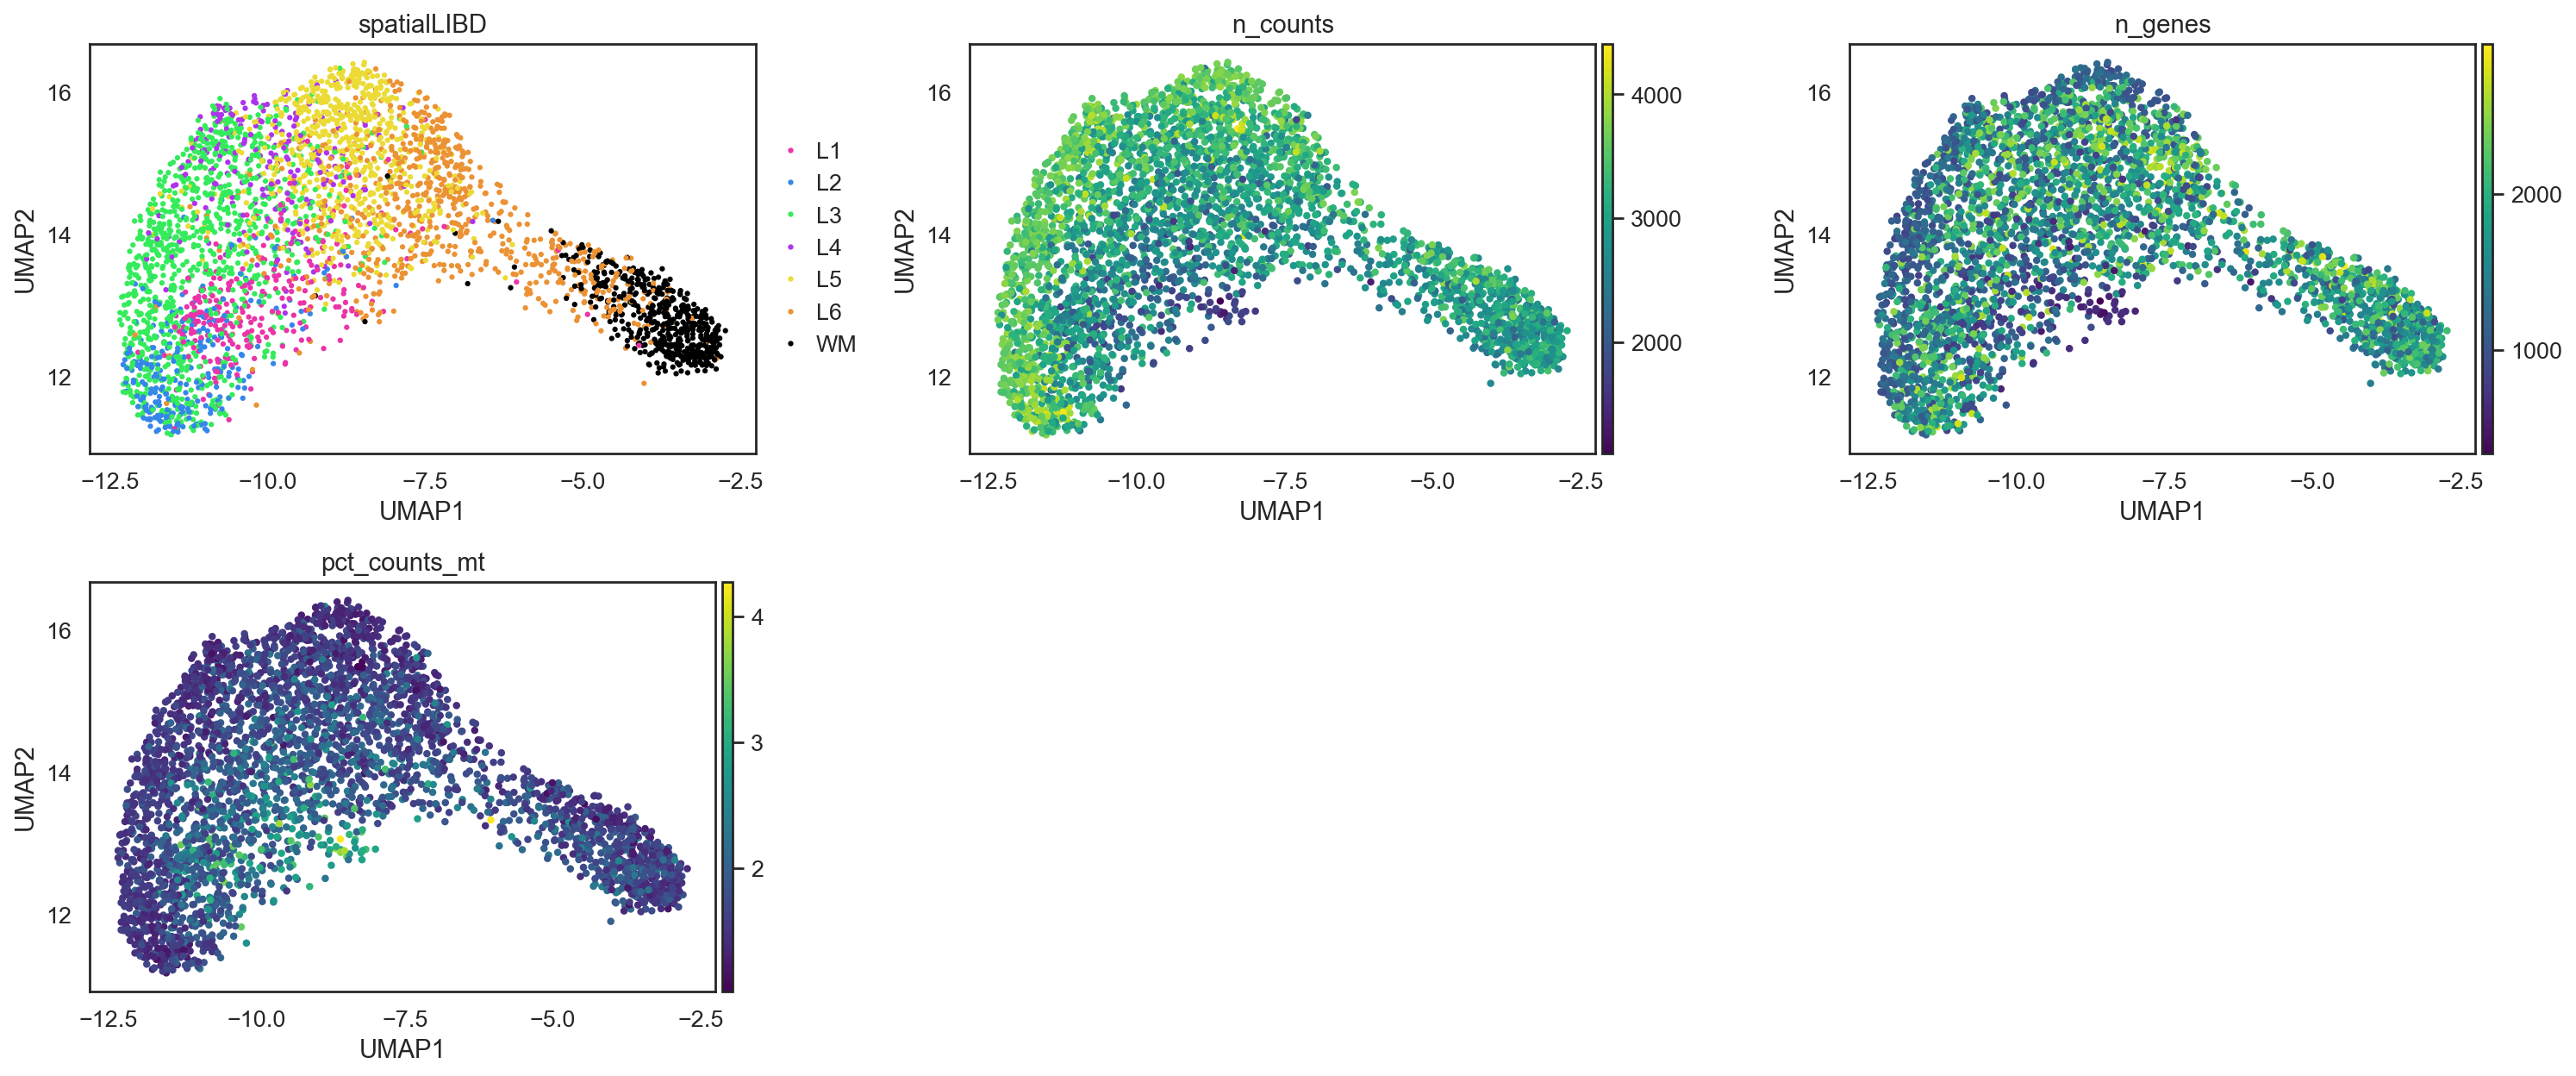

In [199]:
si.pl.umap(
    adata_C,color=['spatialLIBD', 'n_counts', 'n_genes', 'pct_counts_mt'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random',
)

In [159]:
si.preprocessing.pca(adata_C)

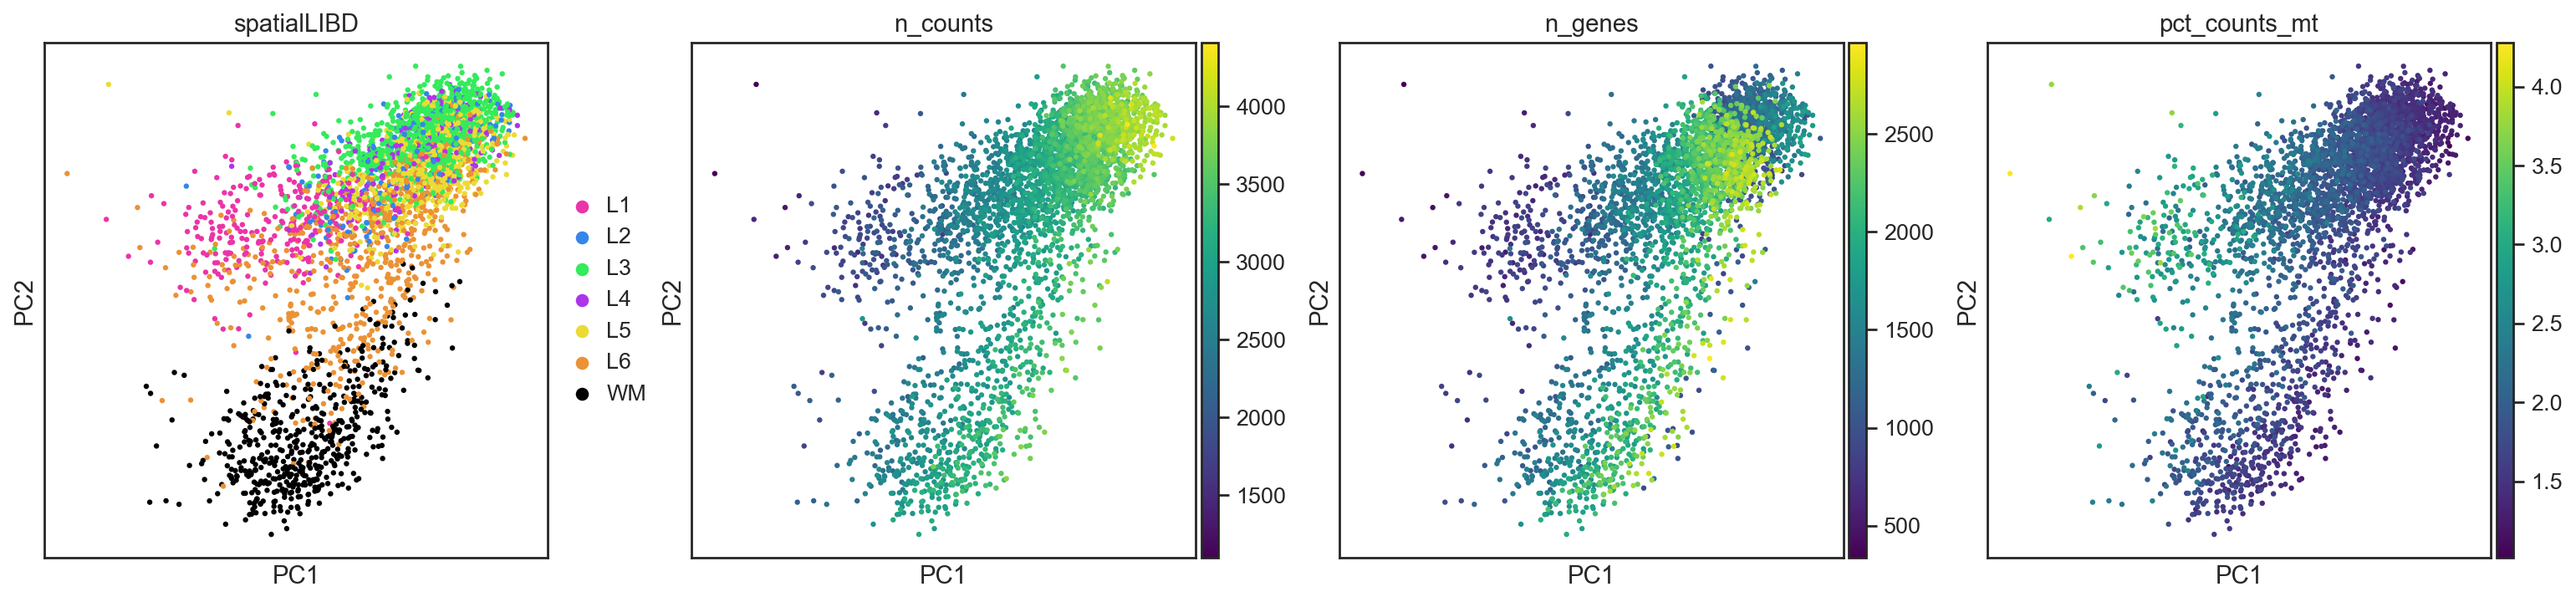

In [200]:
sc.pl.pca(adata_C, color=['spatialLIBD', 'n_counts', 'n_genes', 'pct_counts_mt'], palette=palette_celltype, dimensions=(0, 1))

# Co embedding

In [173]:
# embed cells and genes into the same space
adata_all = si.tl.embed(adata_ref=adata_C,list_adata_query=[adata_G])
adata_all.obs.head()

Performing softmax transformation for query data 0;


spatialLIBD     n_counts  n_genes  pct_counts_mt id_dataset
TCTTACAGAGGTACCG-1          L3  3277.299805   2330.0       1.604911        ref
AGGATAAAGTCGGGAT-1          L6  2527.645264   1330.0       2.019101        ref
GCCTAGCGATCTGACC-1          L4  3036.243896   1924.0       1.724310        ref
TCATTTAGAAGTGTGA-1          L3  4130.114746   1875.0       1.238340        ref
CTGACTGCGCAGCTCG-1          L3  3551.035400   1129.0       1.589211        ref

In [174]:
## add annotations of cells and genes
adata_all.obs['entity_anno'] = ""
adata_all.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all.obs.loc[adata_C.obs_names, 'spatialLIBD']
adata_all.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'
adata_all.obs.head()

spatialLIBD     n_counts  n_genes  pct_counts_mt  \
TCTTACAGAGGTACCG-1          L3  3277.299805   2330.0       1.604911   
AGGATAAAGTCGGGAT-1          L6  2527.645264   1330.0       2.019101   
GCCTAGCGATCTGACC-1          L4  3036.243896   1924.0       1.724310   
TCATTTAGAAGTGTGA-1          L3  4130.114746   1875.0       1.238340   
CTGACTGCGCAGCTCG-1          L3  3551.035400   1129.0       1.589211   

                   id_dataset entity_anno  
TCTTACAGAGGTACCG-1        ref          L3  
AGGATAAAGTCGGGAT-1        ref          L6  
GCCTAGCGATCTGACC-1        ref          L4  
TCATTTAGAAGTGTGA-1        ref          L3  
CTGACTGCGCAGCTCG-1        ref          L3

## All genes

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/simba/plotting/_plot.py:1065: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['color'] = dict()


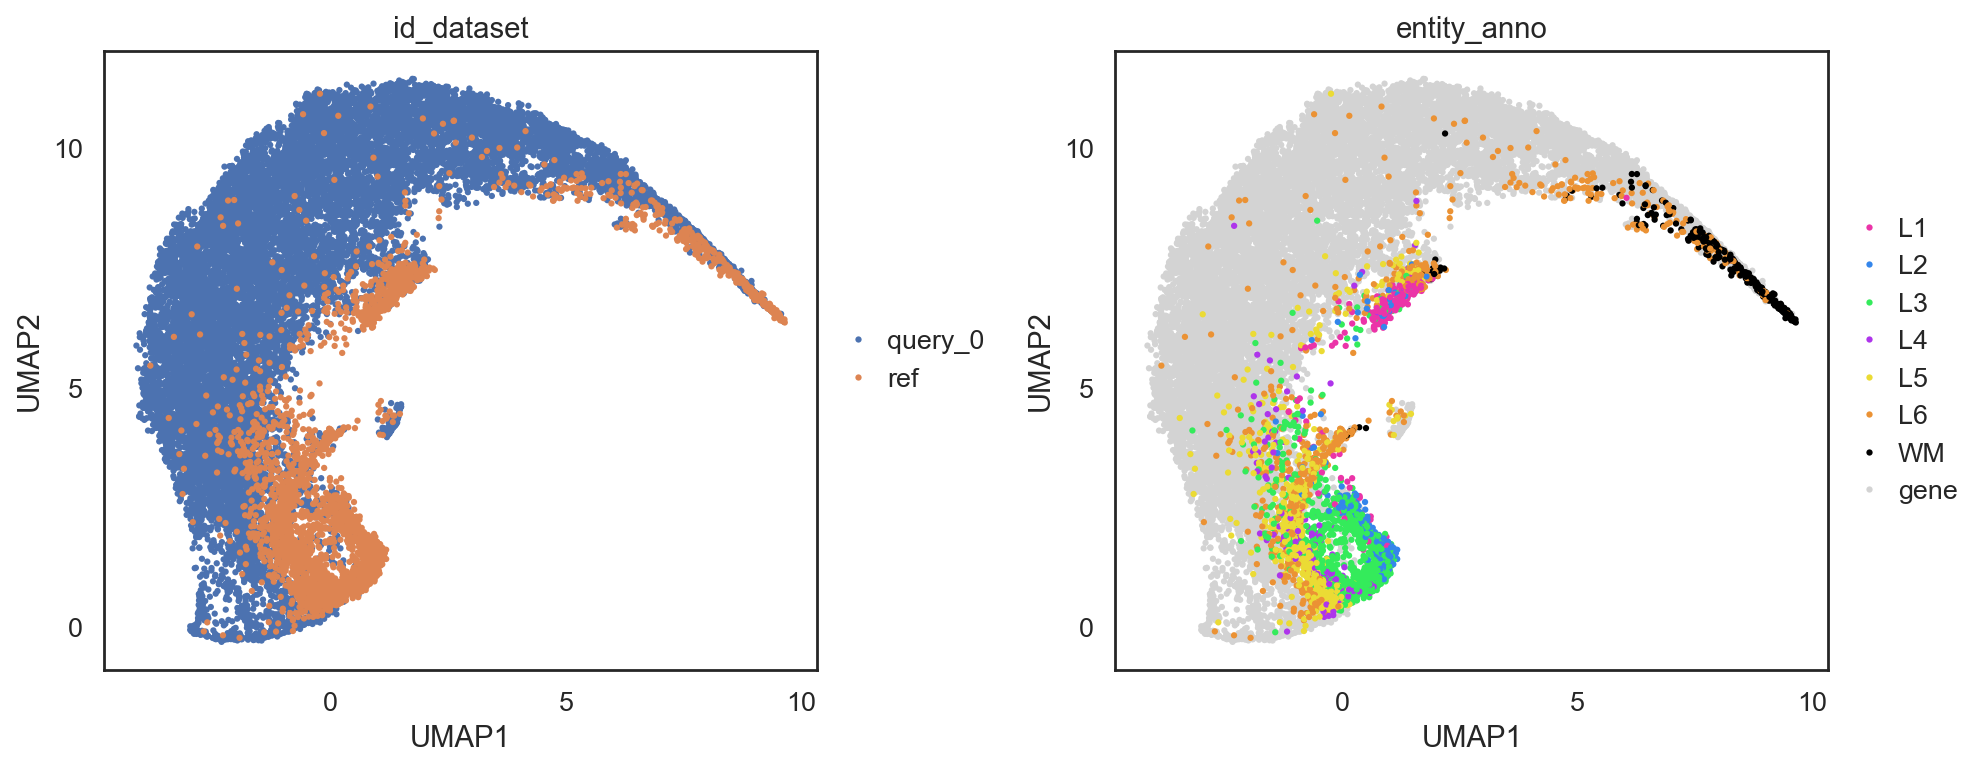

In [201]:
si.tl.umap(adata_all,n_neighbors=15,n_components=2)
si.pl.umap(adata_all[::-1,],color=['id_dataset','entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           fig_size=(6,5))

## Variable genes

In [177]:
si.pp.select_variable_genes(adata_CG_filMT_noMT,layer='counts', n_top_genes=3000)
var_genes = adata_CG_filMT_noMT.var_names[adata_CG_filMT_noMT.var['highly_variable']].tolist()

3000 variable genes are selected.


/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/simba/plotting/_plot.py:1065: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['color'] = dict()


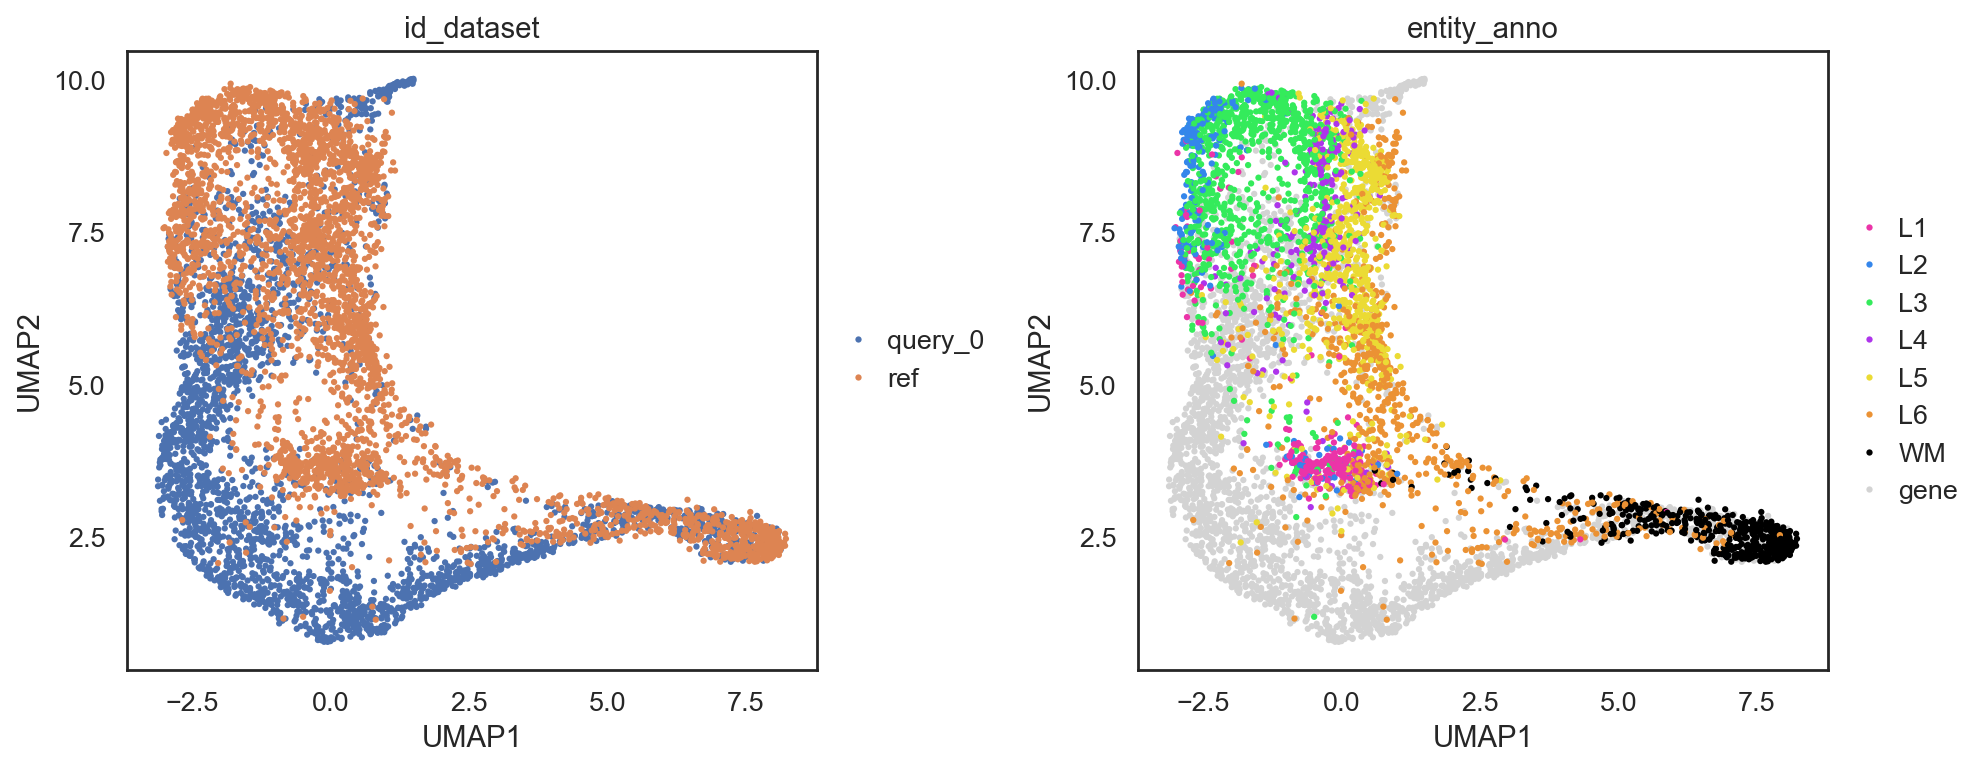

In [202]:
# obtain SIMBA embeddings of cells and variable genes
adata_all2 = adata_all[list(adata_C.obs_names) + var_genes,].copy()
# visualize them using UMAP
si.tl.umap(adata_all2,n_neighbors=15,n_components=2)
si.pl.umap(adata_all2[::-1,], color=['id_dataset','entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           fig_size=(6,5))

# Marker discovery

In [179]:
adata_cmp = si.tl.compare_entities(adata_ref=adata_C, adata_query=adata_G)
adata_cmp

AnnData object with n_obs × n_vars = 3606 × 16565
    obs: 'spatialLIBD', 'n_counts', 'n_genes', 'pct_counts_mt'
    var: 'max', 'std', 'gini', 'entropy'
    layers: 'norm', 'softmax'

In [180]:
adata_cmp.var.sort_values(by='max', ascending=False).head()

max       std      gini   entropy
DNAH17  2.196187  0.915517  0.588705  7.463701
LRP2    2.116382  0.952792  0.598869  7.459902
ABCA8   2.095861  0.897022  0.565795  7.548053
FOLH1   2.087879  0.966048  0.598677  7.471805
GJB1    2.080911  0.958630  0.597216  7.470897

In [181]:
adata_cmp.var['canonical_layer'] = np.nan
adata_cmp.var.loc[
    ["AQP4", "HPCAL1", "FREM3", "TRABD2A", "KRT17", "MOBP"],
    'canonical_layer'
] = ["L1", "L2", "L3", "L5", "L6", "WM"]

/var/folders/h3/49kgmgs54yv7pd7wbst2wfv80000gp/T/ipykernel_78582/3530722609.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['L1', 'L2', 'L3', 'L5', 'L6', 'WM']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata_cmp.var.loc[


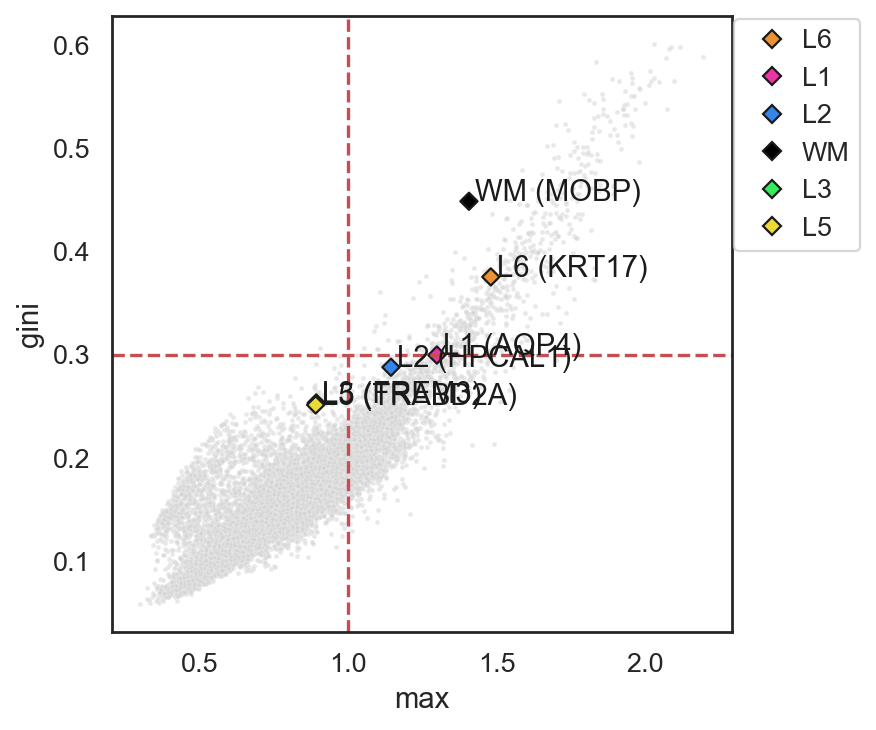

In [203]:
sns.scatterplot(adata_cmp.var, x='max', y='gini', color='lightgray', alpha=0.5, s=5)
sns.scatterplot(adata_cmp.var, x='max', y='gini', hue='canonical_layer', palette=palette_celltype, s=30, marker='D', edgecolors='k', linewidth=1)
for i, r in adata_cmp.var.dropna(subset=['canonical_layer']).iterrows():
    layer = r['canonical_layer']
    plt.text(r['max']+.02, r['gini'], f"{layer} ({i})", color='k')
    
plt.axvline(1.0, linestyle='--', c='r')
plt.axhline(0.3, linestyle='--', c='r')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/simba/plotting/_post_training.py:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt_texts = [plt.text(adata_cmp.var[x][i],
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/simba/plotting/_post_training.py:257: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata_cmp.var[y][i],


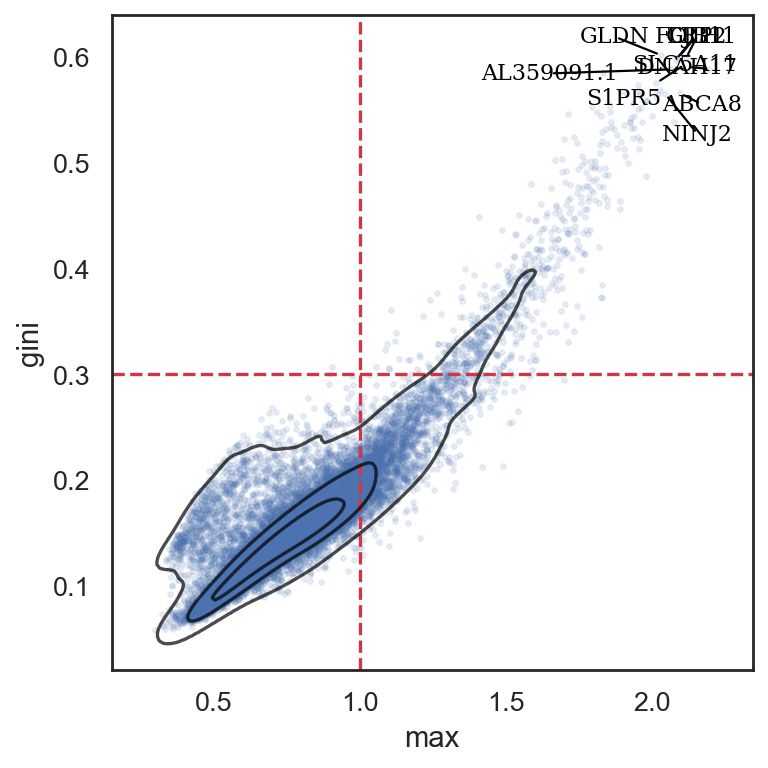

In [204]:
# SIMBA metrics can be visualized using the following function:
si.pl.entity_metrics(adata_cmp,
                     x='max',
                     y='gini',
                     show_contour=True,
                     # texts=marker_genes + ['GAPDH', 'B2M'],
                     show_texts=True,
                     show_cutoff=True,
                     size=5,
                     text_expand=(1.3,1.5),
                     cutoff_x=1.,
                     cutoff_y=0.3,
                     save_fig=False, alpha=0.1)

# Save data

In [205]:
adata_CG_filMT.write(os.path.join(workdir, 'adata_CG_filMT.h5ad'))
adata_CG_filMT_noMT.write(os.path.join(workdir, 'adata_CG_filMT_noMT.h5ad'))
adata_C.write(os.path.join(workdir, 'adata_C.h5ad'))
adata_G.write(os.path.join(workdir, 'adata_G.h5ad'))
adata_all.write(os.path.join(workdir, 'adata_all.h5ad'))
adata_cmp.write(os.path.join(workdir, 'adata_cmp.h5ad'))